## AR Model estimation with approximated likelihood ratios

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

In this case an AR(1) model is used.

The approximation is:
$$ \Lambda(\theta_0, \theta_1) = \prod_{t=1}^N \frac{p(\theta_0 | x_t, x_{t-1})}{p(\theta_1 | x_t, x_{t-1})}\left(\prod_{t=0}^{N-1}\frac{p(\theta_0 | x_t)}{p(\theta_1 | x_t)}\right)^{-1}$$



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
import scipy.linalg as L
import pdb
import pickle

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/../systematics/carl')

import carl

import multiprocessing

#matplotlib.style.use('ggplot')
plt.set_cmap('viridis')

np.random.seed(1234)

In [2]:
import statsmodels.tsa.vector_ar.var_model as vector_ar

In [3]:
p_value_ = 1
ndims_ = 2
nparams_ = 2
N_ = 50000
T_ = 50
alpha_value_0 = 0.5
alpha_value_1 = 0.4
sigma_2_value = [[1.,0.],[0.,1.]]
intercept=[0.,0.]
alpha_value_0_bkg = 0.3
alpha_value_1_bkg = 0.3
sigma_2_value_bkg = [[1.,0.],[0.,1.]]

bounds = [(0.3, 0.6), (0.3, 0.6)]
n_points = 5

As = np.linspace(bounds[0][0],bounds[0][1], n_points)
Bs = np.linspace(bounds[1][0],bounds[1][1], n_points)
AA, BB = np.meshgrid(As, Bs)
AABB = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))


In [4]:
class VAR:

    def sample(self, coefs, intercept, sigma_2, n_steps, rng=None):
        return vector_ar.util.varsim(coefs, intercept, sigma_2, steps=n_steps)
    
    def plot(self,steps=1000):
        self.VAR.plotsim(steps)

    def nll(self, X, alphas, intercept, sigma_2):
        lags = 1
        trend = 'c'
        alpha_0 = alphas[0]
        alpha_1 = alphas[1]
        coefs = np.array([alpha_0,0.,0.,alpha_1]
                        ).reshape(p_value_,ndims_,ndims_)
        
        VAR = vector_ar.VAR(X)
        # have to do this again because select_order doesn't call fit
        VAR.k_trend = k_trend = vector_ar.util.get_trendorder(trend)

        offset = 0
        y = VAR.y[offset:]

        z = vector_ar.util.get_var_endog(y, lags, trend, 
                                         has_constant='skip')
        y_sample = y[lags:]
        intercept = intercept
        params = np.vstack((intercept, coefs.reshape((2,2))))
        #params = np.linalg.lstsq(z, y_sample)[0]
        resid = y_sample - np.dot(z, params)
        omega = np.array(sigma_2)
        
        lastterm = -np.trace(np.dot(np.dot(resid, L.inv(omega)),resid.T))
        
        varfit = vector_ar.VARResults(y, z, params, omega, lags, names=VAR.endog_names,
                    trend=trend, dates=VAR.data.dates, model=self)
        llf = -varfit.llf
        llf += 0.5*lastterm
        return -llf
    
    def rvs(self, n_samples, alpha_0, alpha_1, intercept, sigma_2, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        coefs = np.array([alpha_0,0.,0.,alpha_1]
                        ).reshape(p_value_,ndims_,ndims_)
        return self.sample(coefs=coefs,intercept=intercept,
                           sigma_2=sigma_2,
                           n_steps=n_samples,rng=rng)

In [5]:
p0 = VAR()
p1 = VAR()
rng = np.random.RandomState(1234)

n_true = 1000
#X_true = p0.rvs(1000,random_state=rng)
X_true = np.array([p0.rvs(T_, alpha_value_0, alpha_value_1, intercept,
                          sigma_2_value, random_state=np.random.randint(0,5000))
                   for i in range(n_true)])

In [6]:
from itertools import product
bounds_values = [(np.linspace(bounds[0][0],bounds[0][1], num=5)),
                 (np.linspace(bounds[1][0],bounds[1][1], num=5))]
combinations = list(product(*bounds_values))

In [7]:
def produce_data(value):
    return np.array([p0.rvs(T_, value[0], value[1], intercept, sigma_2_value,
                           random_state=np.random.randint(0,5000))
                   for i in range(N_//2)])   

In [97]:
Xs = []
ys = []
num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores)
Xs = pool.map(produce_data, values)
X1_ = np.array([p1.rvs(T_, alpha_value_0_bkg, alpha_value_1_bkg, 
                       intercept, sigma_2_value,
                       random_state=np.random.randint(0,5000))
               for i in range(N_//2)])
Xs = np.array(Xs)

In [38]:
#X_min = Xs.min(axis=1).min(axis=0)[:2]
#X_true_min = X_true.min(axis=0)
#Xs_min = np.vstack((X_min, X_true_min)).min(axis=0)

In [49]:
#X_c = np.hstack((np.log(X[:,:,:2] + 1. - Xs_min), X[:,2:]))
#X_true_c = np.log(X_true + 1. - Xs_min)

In [ ]:
#X = X_c
#X_true = X_true_c

In [ ]:
X = Xs[0][0]

-1.98636030533 2.92214859815
-2.50343831996 2.811622886


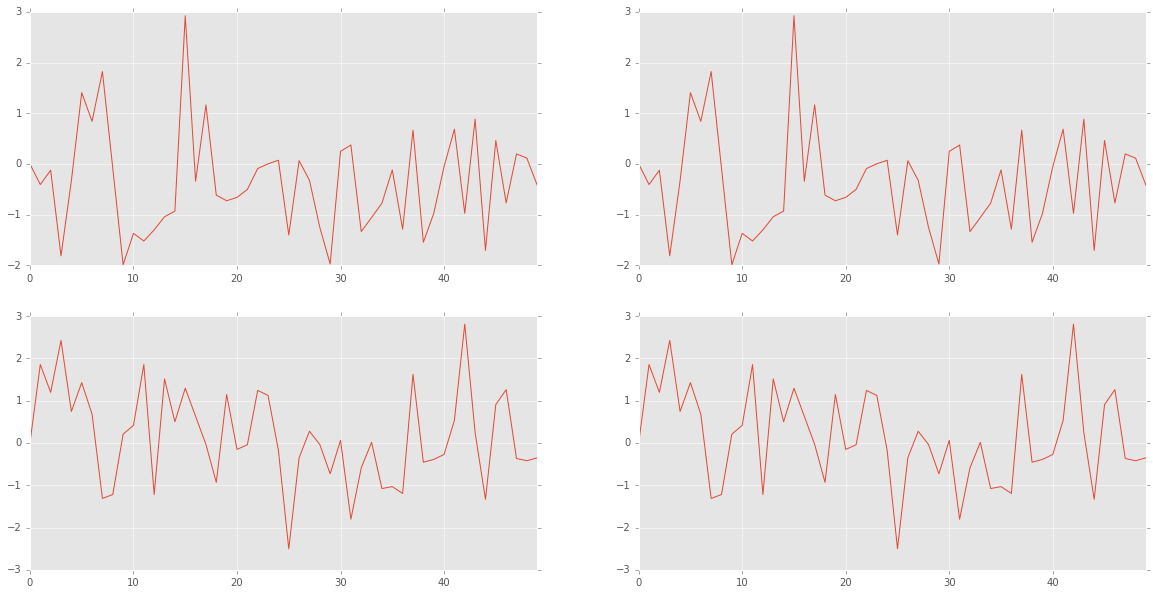

In [51]:
serie1 = X1_[0][:,0]
serie2 = Xs[0][0][:,0]
plt.figure(figsize=(20,10))
plt.subplot(211)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(212)
ts = pd.Series(serie1)
ts.plot()

In [8]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit


Using Theano backend.


In [ ]:
def make_model_join():
    model = Sequential()
    model.add(GRU(15, input_shape=(T_, ndims_)))
    model.add(Dense(5, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    sgd = Adam(clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model

In [ ]:
def make_ratio(num):
    X_num = Xs[num]
    X_den = X1_
    X = np.vstack((X_num, X_den))
    y = np.zeros(len(X_num) + len(X_den), dtype=np.int)
    y[len(X_num):] = 1

    clf = KerasClassifier(make_model_join, nb_epoch=50, verbose=0)

    cv =  StratifiedShuffleSplit(n_iter=1, test_size=0.5, random_state=1)

    ratio = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=20),
        random_state=0)
    ratio.fit(X, y)
    
    #print('Loss {0} : {1}'.format(num, log_loss(ratio.classifier_.classifiers_[0].
    #               predict(X[:int(len(X)*0.3)]),y[:int(len(X)*0.3)])))
    
    return ratio


In [ ]:
print('Start training')
num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores)

n_sample_points = len(combinations)
points = list(range(n_sample_points))
for i, k in enumerate([points[n:n + num_cores] for n in range(0, n_sample_points, num_cores)]):
    print('Iteration {0}'.format(i))
    clf_ratios += pool.map(make_ratio, k)

print('End training')

llr = []
zeros = []
distances = []

for i, theta in enumerate(combinations):
    print(i, theta)
    ratio = clf_ratios[i]
    ratios = ratio.predict(X_true, log=True)
    print ratios[np.isinf(ratios)].shape
    zeros.append(ratios[np.isinf(ratios)].shape[0])
    ratios = ratios[np.logical_and(np.isfinite(ratios),~np.isnan(ratios))]
    nllr = -np.mean(ratios) 
    llr.append(nllr)
    print(llr[-1])

In [90]:
llr = np.array(llr)
llr[np.isnan(llr)] = 0.

In [25]:
# Computing exact likelihood
exact_contours = np.zeros(len(AABB))
combinations = product(As, Bs)
i = 0
for a in As:    
    for b in Bs:
        exact_contours[i] = np.mean([p0.nll(X_true[k], [a,b], intercept, sigma_2_value) 
                                     for k in range(100)])
        i += 1

In [9]:
llr, zeros = pickle.load(open('data/ar_results.dat', 'r'))

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.1f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '


/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:304: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


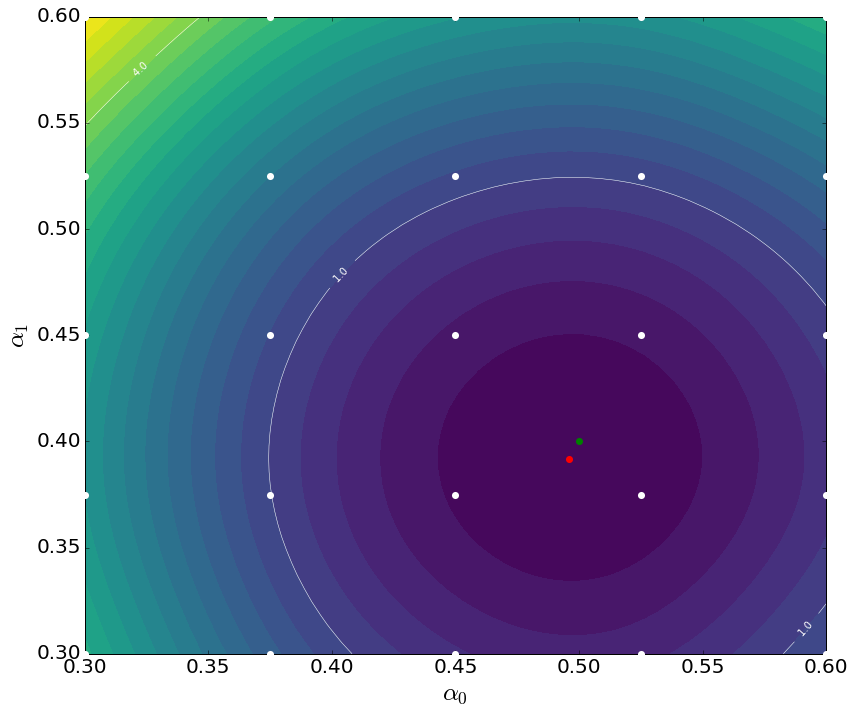

In [26]:
thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, exact_contours)

xi = np.linspace(bounds[0][0], bounds[0][1], 50)
yi = np.linspace(bounds[1][0], bounds[1][1], 50)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.
#zi = np.flipud(zi.transpose())

cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
plt.clabel(cs, cs.levels, inline=1, fontsize=10, fmt = fmt)

cs = plt.contourf(xi, yi, zi, 30,
                  vmax=abs(zi).max(), vmin=0.0)
#plt.clabel(cs, inline=1, fontsize=10)

#plt.colorbar()
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([alpha_value_0],[alpha_value_1], marker='o', c='g', s=50, lw=0, zorder=10)
#plt.scatter([theta[theta1, 1]], [theta[theta1, 2]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel(r"$\alpha_0$", fontsize=25)
plt.ylabel(r"$\alpha_1$", fontsize=25)
plt.tight_layout()
plt.savefig('plots/alpha_gp_exact.pdf')
plt.show()
#plt.close()
#plt.clf()

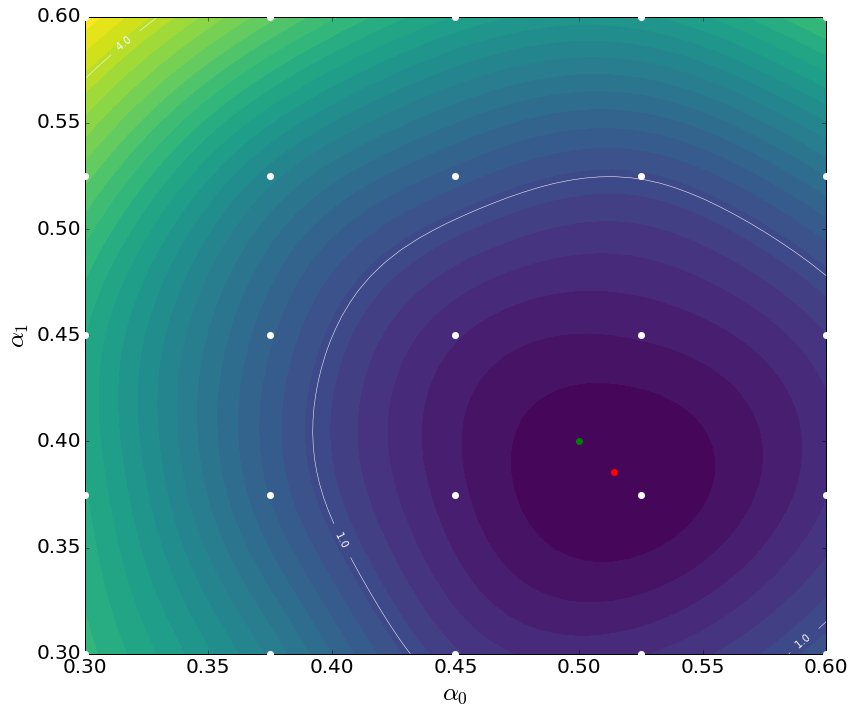

In [24]:
thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 50)
yi = np.linspace(bounds[1][0], bounds[1][1], 50)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.
#zi = np.flipud(zi.transpose())

cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
plt.clabel(cs, cs.levels, inline=1, fontsize=10, fmt = fmt)

cs = plt.contourf(xi, yi, zi, 30,
                  vmax=abs(zi).max(), vmin=0.0)
#plt.clabel(cs, inline=1, fontsize=10)

#plt.colorbar()
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([alpha_value_0],[alpha_value_1], marker='o', c='g', s=50, lw=0, zorder=10)
#plt.scatter([theta[theta1, 1]], [theta[theta1, 2]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel(r"$\alpha_0$", fontsize=25)
plt.ylabel(r"$\alpha_1$", fontsize=25)
plt.tight_layout()
plt.savefig('plots/alpha_gp_approx.pdf')
plt.show()
#plt.close()
#plt.clf()

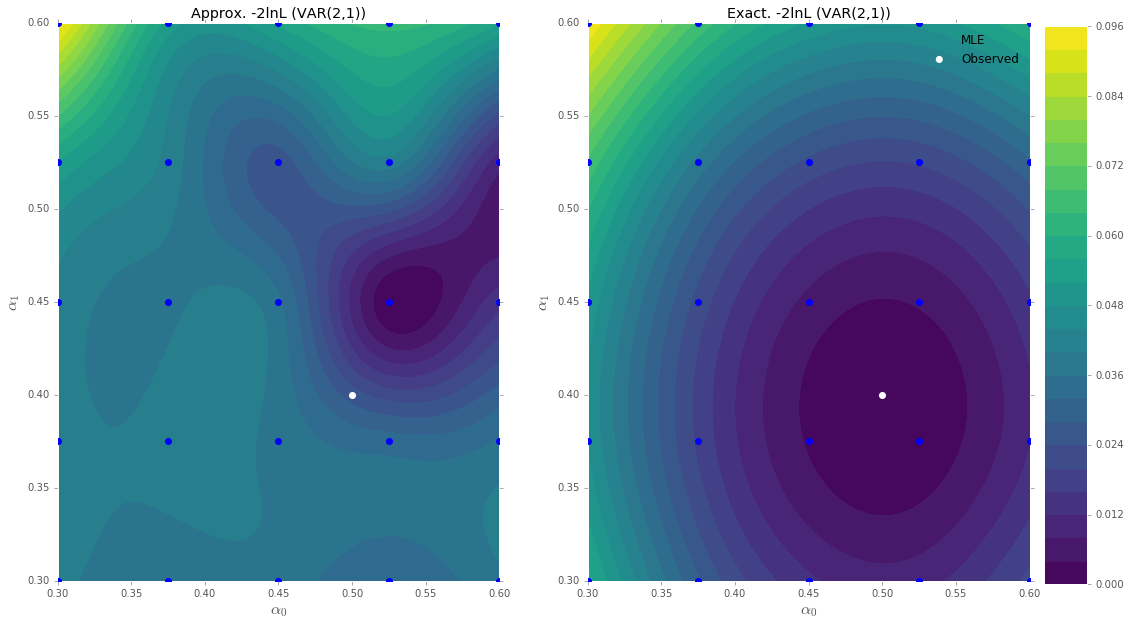

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax = axes.flat[0]

thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs = ax.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs.levels = [nf(val) for val in cs.levels]
ax.clabel(cs, cs.levels, inline=1, fontsize=10, fmt = fmt)
cs = ax.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)

#plt.colorbar()
ax.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
ax.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
ax.scatter([alpha_value_0],[alpha_value_1], marker='o', c='w', s=50, lw=0, zorder=10)

ax.set_xlim(bounds[0][0], bounds[0][1])
ax.set_ylim(bounds[1][0], bounds[1][1])
ax.set_xlabel(r"$\alpha_0$", size=16)
ax.set_ylabel(r"$\alpha_1$", size=16)
ax.set_title("Approx. -2lnL (VAR(2,1))")

ax = axes.flat[1]

thetas = np.array([c for c in product(As, Bs)])
gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, exact_contours)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs2 = ax.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs2.levels = [nf(val) for val in cs2.levels]
ax.clabel(cs2, cs2.levels, inline=1, fontsize=10, fmt = fmt)
cs2 = ax.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.12, 0.03, 0.775])
fig.colorbar(cs2, cax=cbar_ax)

ax.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
smle = ax.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
sobs = ax.scatter([alpha_value_0],[alpha_value_1], marker='o', c='w', s=50, lw=0, zorder=10)

lines = [smle, sobs]
labels = ['MLE', 'Observed']

ax.legend(lines, labels, frameon=False, prop={'size':12}, scatterpoints=1)

ax.set_xlim(bounds[0][0], bounds[0][1])
ax.set_ylim(bounds[1][0], bounds[1][1])
ax.set_xlabel(r"$\alpha_0$", size=16)
ax.set_ylabel(r"$\alpha_1$", size=16)
ax.set_title("Exact. -2lnL (VAR(2,1))")

plt.show()
#plt.savefig('ar_2d_approx.pdf')

In [219]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf_join, bins=30, cv='prefit', 
                                         method='histogram'), 
    random_state=0)

cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x119c29d0>,
            bins=30, cv='prefit', method='histogram'),
        random_state=0)

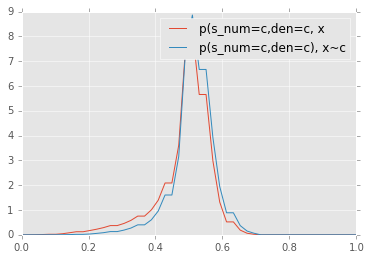

In [220]:
reals2 = np.linspace(0, 1)
cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [224]:

from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

n_samples = 500
T_ = 500
def objective(theta, X_true = X_true, random_state=0):    
    print(theta)
    shared_alpha_0.set_value(theta[0])
    shared_alpha_1.set_value(theta[1])
    theta_array = np.empty((n_samples,len(theta)))
    def transform(x): return np.log(x + 1. - Xs_min)
    for i,v in enumerate(theta):
        theta_array[:,i].fill(v)
    serie1 = np.array([np.hstack((transform(p0.rvs(n_samples, 
                                                    random_state=np.random.randint(0,5000))),theta_array)) 
                   for i in range(T_//2)])
    for i in range(T_//2):
        if i == 0:
            X0 =  serie1[i]
        else:
            X0 = np.vstack((X0, serie1[i]))

    for i,v in enumerate(theta):
        theta_array[:,i].fill(v)
    serie2 = np.array([np.hstack((transform(p1.rvs(n_samples, 
                                                    random_state=np.random.randint(0,5000))),theta_array)) 
                   for i in range(T_//2)])
    for i in range(T_//2):
        if i == 0:
            X1 =  serie2[i]
        else:
            X1 = np.vstack((X1, serie2[i])) 

    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]+X1_serie.shape[1],dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1

    # Fit ratio
    ratio_join = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_join, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=20))
    
    ratio_join.fit(X_serie, y_serie)
    
    # Fit ratio
    ratio_single = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_single, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=20))
    
    X_single = X_serie[:,0,:]
    y_single = y_serie[:]
    
    ratio_single.fit(X_single, y_single)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+nparams_))
    X_true_[:,:-nparams_] = X_true
    X_true_[:,-nparams_:] = theta
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    
    r_join = ratio_join.predict(X_true_serie, log=True)
    r_single = -ratio_single.predict(X_true_serie[:,0,:], log=True)
    
    r_full = r_join[1:] + r_single[:-1]
    #r_full = r_join
    
    print r_full[np.isinf(r_full)].shape
    r_full = r_full[np.logical_and(np.isfinite(r_full),~np.isnan(r_full))]
    if r_full.size > 0:
        value = -np.mean(r_full)  # optimization is more stable using mean this will need to be rescaled by len(X_true)
    else:
        value = 0.
    print(value)
    #return r_full, serie1, serie2, ratio_join
    return value

In [155]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

n_samples = 250000
def objective(theta, X_true = X_true, random_state=0):    
    print(theta)
    shared_alpha_0.set_value(theta[0])
    shared_alpha_1.set_value(theta[1])
    serie1 = p0.rvs(n_samples)
    serie1 = np.log(serie1 + 1. - Xs_min)
    serie1[np.isnan(serie1)] = 0.
    serie1[np.isinf(serie1)] = 0.
    # Set parameter values   
    X0 = np.zeros((serie1.shape[0],serie1.shape[1]+nparams_))
    X0[:,:-nparams_] = serie1
    X0[:,-nparams_:] = theta    
    # Fit ratio
    ratio_join = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_join, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=20))

    #serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
    serie2 = p1.rvs(n_samples,random_state=random_state)
    serie2 = np.log(serie2 + 1. - Xs_min)
    serie2[np.isnan(serie2)] = 0.
    serie2[np.isinf(serie2)] = 0.

    X1 = np.zeros((serie2.shape[0],serie2.shape[1]+nparams_))
    X1[:,:-nparams_] = serie2
    X1[:,-nparams_:] = theta
    pdb.set_trace()
    
    X0_serie = []
    X1_serie = []

    for i in xrange(serie1.shape[0]-max_len):
        X0_serie.append(X0[i:i+max_len])
        X1_serie.append(X1[i:i+max_len])
    X0_serie = np.array(X0_serie)
    X1_serie = np.array(X1_serie)

    X_serie = np.vstack((
         X0_serie,
         X1_serie))
    y_serie = np.zeros(X0_serie.shape[0]+X1_serie.shape[1],dtype=np.int)
    y_serie[X0_serie.shape[0]:] = 1
    
    ratio_join.fit(X_serie, y_serie)
    
    # Fit ratio
    ratio_single = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf_single, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=20))
    
    X_single = X_serie[:,0,:]
    y_single = y_serie[:]
    
    ratio_single.fit(X_single, y_single)
    
    # Evaluate log-likelihood ratio
    X_true_ = np.zeros((X_true.shape[0],X_true.shape[1]+nparams_))
    X_true_[:,:-nparams_] = X_true
    X_true_[:,-nparams_:] = theta
    
    X_true_serie = []
    for i in xrange(X_true_.shape[0]-max_len):
        X_true_serie.append(X_true_[i:i+max_len])
    X_true_serie = np.array(X_true_serie)
    
    r_join = ratio_join.predict(X_true_serie, log=True)
    r_single = -ratio_single.predict(X_true_serie[:,0,:], log=True)
    
    #r_full = r_join[1:] + r_single[:-1]
    r_full = r_join
    
    print r_full[np.isinf(r_full)].shape
    #r_full = r_full[np.logical_and(np.isfinite(r_full),~np.isnan(r_full))]
    #if r_full.size > 0:
    #    value = -np.mean(r_full)  # optimization is more stable using mean this will need to be rescaled by len(X_true)
    #else:
    #    value = 0.
    #print(value)
    return r_full, serie1, serie2, ratio_join
    return value

In [147]:
ratio_join.classifier_.predict_proba(X_true_serie[3].reshape(1,2,4))

array([[ 1.,  0.]])

In [64]:
ratio_join.predict(X_true_serie[11].reshape(1,2,4))

array([ inf])

In [151]:
print(X_true.shape)

(15000, 2)


In [104]:
from GPyOpt.methods import BayesianOptimization
bounds = [(0.1,0.5)]
solver = BayesianOptimization(vectorize(objective), bounds)
solver.run_optimization(max_iter=50, true_gradients=False)

[ 0.22384972]
(1,)
-0.00216551454125
[ 0.23066371]
(2,)
-0.000441152391242
[ 0.10198037]
(1,)
0.0471657688529
[ 0.49606812]
(9,)
-0.0453178636723
[ 0.45284154]
(2,)
-0.0453358845761
[ 0.46182173]
(2,)
-0.0424479348349
[ 0.5]
(5,)
-0.0458649533748
[ 0.5]
(2,)
-0.0426062066234
*Optimization completed:
   -Method converged.


0

In [ ]:
approx_MLE = solver.x_opt
print solver.x_opt
print("Approx. MLE =", approx_MLE)

In [ ]:
solver.plot_acquisition()

In [ ]:
solver.plot_convergence()

In [ ]:
from scipy.optimize import minimize
shared_alpha.set_value(alpha_value)
# Minimize the surrogate GP approximate of the approximate LR
def gp_objective(theta):
    theta = theta.reshape(1, -1)
    return solver.model.predict(theta)[0][0]

r = minimize(gp_objective, x0=[0.4])
gp_MLE = r.x

print("GP MLE =", gp_MLE)

In [ ]:
#bounds = [(exact_MLE[0] - 0.16, exact_MLE[0] + 0.16)]
#bounds = [(38., 58.0)]
As = np.linspace(bounds[0][0],bounds[0][1], 50)

n_points = 30

clf = clf
n_samples = n_samples
#As = np.linspace(*bounds[0], 100)
nll_gp, var_gp = solver.model.predict(As.reshape(-1, 1))
nll_gp = 2. * (nll_gp - nll_gp.min()) * len(X_true)
gp_ratios = nll_gp
# STD
std_gp = np.sqrt(4*var_gp*len(X_true)*len(X_true))
std_gp[np.isnan(std_gp)] = 0.
gp_std = std_gp
# 95% CI
q1_gp, q2_gp = solver.model.predict_quantiles(As.reshape(-1, 1))
q1_gp = 2. * (q1_gp - r.fun) * len(X_true)
q2_gp = 2. * (q2_gp - r.fun) * len(X_true)
gp_q1 = q1_gp
gp_q2 = q2_gp

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
print gp_ratios

ax.plot(As, gp_ratios, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
#ax.fill_between(As,(gp_ratios - gp_std).ravel(),(gp_ratios + gp_std).ravel(),
#                     color='g',alpha=0.2)
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")
#plt.legend()


ax.legend()
ax.set_ylim(0, 14)
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=0.3**2,ymin=0.,ymax=4.,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model